In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model, BertTokenizer, BertModel
import logging
import pickle
from tqdm import tqdm


logging.basicConfig(level=logging.INFO)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Load the Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


def extract_wav2vec_features(audio, max_length=250):
    """
    Extract features from audio using Wav2Vec2 model.
    
    Args:
    audio (np.array): Audio signal
    max_length (int): Maximum length of features to return
    
    Returns:
    np.array: Extracted features, padded or truncated to max_length
    """
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        outputs = wav2vec_model(input_values)
    features = outputs.last_hidden_state.squeeze().numpy()
    return pad_or_truncate(features, max_length)

def extract_mfcc(audio, sr=16000, n_mfcc=13):
    """
    Extract MFCC features from audio.
    
    Args:
    audio (np.array): Audio signal
    sr (int): Sampling rate
    n_mfcc (int): Number of MFCC coefficients to compute
    
    Returns:
    np.array: MFCC features
    """
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

def extract_bert_features(text, max_length=128):
    """
    Extract features from text using BERT model.
    
    Args:
    text (str): Input text
    max_length (int): Maximum length of input tokens
    
    Returns:
    np.array: Extracted features
    """
    inputs = bert_tokenizer(text, return_tensors="pt", max_length=max_length, padding="max_length", truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.squeeze(0).numpy()

def pad_or_truncate(array, target_length, axis=0):
    """
    Pad or truncate an array to a target length along a given axis.
    
    Args:
    array (np.array): Input array
    target_length (int): Desired length of the array
    axis (int): Axis along which to pad or truncate
    
    Returns:
    np.array: Padded or truncated array
    """
    if array.shape[axis] > target_length:
        slices = [slice(None)] * array.ndim
        slices[axis] = slice(0, target_length)
        return array[tuple(slices)]
    elif array.shape[axis] < target_length:
        pad_width = [(0, 0)] * array.ndim
        pad_width[axis] = (0, target_length - array.shape[axis])
        return np.pad(array, pad_width, mode='constant')
    return array

def engineer_features(X, metadata_df):
    """
    Engineer features from audio samples and metadata.
    
    Args:
    X (list): List of audio samples
    metadata_df (pd.DataFrame): DataFrame containing metadata
    
    Returns:
    np.array: Engineered features
    """
    max_wav2vec_length = 250
    max_mfcc_length = 200
    max_bert_length = 128

    features = []
    for audio, meta in tqdm(zip(X, metadata_df.itertuples()), total=len(X), desc="Extracting features"):
        wav2vec_features = extract_wav2vec_features(audio, max_length=max_wav2vec_length)
        mfcc_features = pad_or_truncate(extract_mfcc(audio), max_mfcc_length, axis=1)
        bert_features = extract_bert_features(meta.statement, max_length=max_bert_length)
        
        combined_features = np.concatenate([
            wav2vec_features.flatten(),
            mfcc_features.flatten(),
            bert_features.flatten(),
        ])
        
        features.append(combined_features)

    return np.array(features)


Loaded 50 audio samples
Metadata summary:
          modality vocal_channel emotion emotional_intensity  \
count           50            50      50                  50   
unique           1             1       6                   2   
top     audio-only          song   angry              normal   
freq            50            50      18                  25   
mean           NaN           NaN     NaN                 NaN   
std            NaN           NaN     NaN                 NaN   
min            NaN           NaN     NaN                 NaN   
25%            NaN           NaN     NaN                 NaN   
50%            NaN           NaN     NaN                 NaN   
75%            NaN           NaN     NaN                 NaN   
max            NaN           NaN     NaN                 NaN   

                           statement  repetition     actor gender  
count                             50   50.000000  50.00000     50  
unique                             2         NaN     

Extracting features: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


Engineered features shape: (50, 292904)


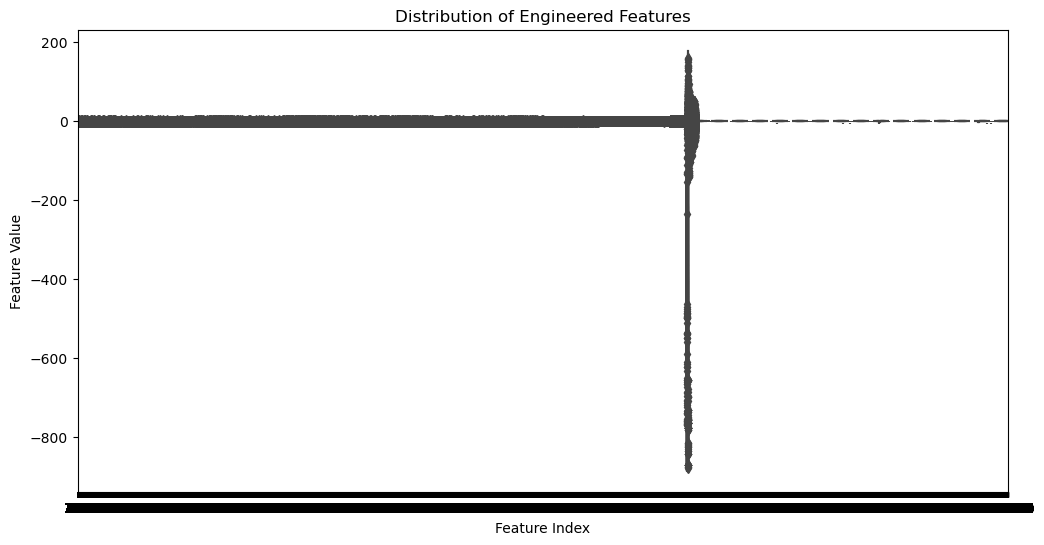

Engineered features and updated metadata saved successfully.


In [8]:
# Load metadata summary
with open('data/metadata_summary.pkl', 'rb') as f:
    metadata_summary = pickle.load(f)

# Load audio data
X = [np.load(f'data/audio_sample_{i}.npy') for i in range(metadata_summary['num_samples'])]

# Load metadata
metadata_df = pd.read_csv('data/metadata.csv')

print(f"Loaded {len(X)} audio samples")
print("Metadata summary:")
print(metadata_df.describe(include='all'))

# Feature engineering
X_engineered = engineer_features(X, metadata_df)
print("Engineered features shape:", X_engineered.shape)

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_engineered)
plt.title("Distribution of Engineered Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

# Save engineered features
np.save('data/engineered_features.npy', X_engineered)

# Update metadata summary
metadata_summary['engineered_features_shape'] = X_engineered.shape

with open('data/metadata_summary.pkl', 'wb') as f:
    pickle.dump(metadata_summary, f)

print("Engineered features and updated metadata saved successfully.")

